In [1]:
# project imports
import sys
sys.path.append('/home/mark/Documents/code/drone/sumo/utils')
from runSumo import runSumo
from sumo_loop import sumo_loop

# general imports
import os
import subprocess
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pickle
import pandas as pd

# plotting params
from IPython.display import Math
# MATPLOTLIB
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# colors used
ORANGE_SCALE = ['#FFC999','#FFA04D','#FF7803']
NEW_SCALE = ['#FF9132','#008F00','#8A2BE2']
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 2.5
FIG_HEIGHT = 2.5

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})

For the experiments I simulated two variants of roads:

**(1) Two-Lane Road**
- 30 mph speedlimit    
- 500 meter road length
- 25 stops
- 1 hour long simulations

**(2) Three-Lane Road**
- 50 mph speedlimit    
- 2000 meter road length
- 100 stops
- 1.5 hour long simulations

**(2) Four-Lane Road**
- 50 mph speedlimit    
- 3000 meter road length
- 150 stops
- 1.5 hour long simulations

For all three roads I vary the **ratio** (truck flow:total flow) from **0.001 to 0.5** logarithmically. 

For road **(1)** I vary the total **flow** from **10 to 3000 veh/hour** in increments of 10

For road **(2)** I vary the total **flow** from **10 to 4500 veh/hour** in increments of 10

For road **(3)** I vary the total **flow** from **10 to 6000 veh/hour** in increments of 10

Flow is distributed so that the probability of a car **entering** the road from any lane is equivalant. Trucks on the other hand can choose the lane freely. This fixes some problems with SUMO forcing all cars to travel on the left lane, limiting their flow as each lane can only provide 1 car/sec. 


In [2]:
# Lets load in some of the simulations from the two lane road
keys = ['2','3','4']

sim_dir = {'2':'/media/mark/Ubuntu/results/new_drone/2_lane/',
           '3':'/media/mark/Ubuntu/results/new_drone/3_lane/',
           '4':'/media/mark/Ubuntu/results/new_drone/4_lane/'}

SAVE_PATHS = {'2':'/home/mark/Documents/code/drone/sumo/results/2_lane/',
              '3':'/home/mark/Documents/code/drone/sumo/results/3_lane/',
              '4':'/home/mark/Documents/code/drone/sumo/results/4_lane/'}

FINAL_SAVE = '/home/mark/Documents/latex/Drone_transC/figures/'

# W = {'2': np.array([4.12525963e-03, 5.35954005e-05, 5.98697238e-01]),
#      '3': np.array([2.94598421e-03, 1.03327147e-04, 2.44155661e+00]),
#      '4': np.array([1.50397659e-03, 8.81281915e-05, 3.74193555e+00])}

base_caps = {'2': 2670, '3': 4040, '4': 5300}

base_caps_idx = {'2': 267-1, '3': 404-1, '4': 530-1}

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_temp = np.convolve(y, box, mode='valid')
    added_len = len(y)-len(y_temp)
    if added_len%2 == 0:
        pads = [added_len//2,added_len//2]
    else:
        pads = [(added_len//2)+1,added_len//2]
    y_smooth = np.concatenate((np.ones(pads[0])*y_temp[0],y_temp,y_temp[-1]*np.ones(pads[1])))
    return y_smooth

In [4]:
ratios = np.logspace(np.log10(0.001),np.log10(0.1),100)
r_idxs = [0,50,99]
ratio = ratios[r_idxs]

print(ratio)
# we can create some plot tools
# colors = ['y', ORANGE, 'r']
# colors = ORANGE_SCALE
color_key = {'2':ORANGE,'3':GREEN,'4':PURPLE}
axs_key = {'2':0,'3':1,'4':2}
ratio_title ={'2':'Two Lane Road','3':'Three Lane Road','4':'Four Lane Road'}
r_labels = ["$0.1\%$","$1\%$","$10\%$"]
# flow_axs = {'2':[0,1000,2000,2636,3000],'3':[1500,2500,3500,3930,4500],'4':[3000,4000,5000,5264,6000]}
# flow_axs_lim = {'2':[0,3000],'3':[1500,4500],'4':[3000,6000]}
# y_axs = {'2':[0,1000,2000,base_caps['2'],3000],'3':[0,1500,3000,base_caps['3'],4500],'4':[0,2000,4000,base_caps['4'],6000]}
y_axs_lim = {'2':[0,5],'3':[0,10],'4':[0,10]}
annotation_y = {'2':-50,'3':-200,'4':-220}

[0.001      0.01023531 0.1       ]


In [5]:
end_index = 10
ffl = {}

for key in keys:
    data = pickle.load(open(SAVE_PATHS[key]+'latency.p','rb'))
    l = data['l']
    ffl[key]=np.mean(l[0,0:end_index])

print(ffl)

{'2': 0.687756692400056, '3': 2.6141339196535847, '4': 3.8939236495946394}


For each ratio and flow pair, we look at the arrival times (arrival = left the road) of **all vehicles** throughout the simulation. 

Since the **flow-in** of traffic is **constant during the first hour** of simulation, I expect the road to be most resemblent of **steady state**  during the middle of this timeframe. Hence to calculate the flow on (out) the road, **I divide the total number of arrivals between the 15 minute mark and the 45 minute mark by 30 minutes.** 

To better visualize what is going on, below I show what happens when I window the arrival rates (# of arrivals at time t) by 30 minutes throughout the entire simulation. The point at **t=30 minutes** represents the **steady state flow out.**

Before I plug in values into the BPR model, lets see what the latency of the cars actually looked like throughout the simulation. Using the same method, I average the latency of cars that have **arrived** between minute 15 and 45. 

In [6]:
# SMOOTHS = [5,10,40]
# colors = [ORANGE, GREEN, PURPLE]

# fig = plt.figure(figsize=(FIG_WIDTH,FIG_HEIGHT))
# widths = [0.33,0.33,0.33]
# heights = [1]
# spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
#                         height_ratios=heights,
#                         left=0.1,
#                         bottom=0.16,
#                         right=0.98,
#                         top=0.9)

# spec.update(wspace=0.1, hspace=0.1)

# for key in keys:
#     # load data
#     data = pickle.load(open(SAVE_PATHS[key]+'latency.p','rb'))
#     flows = data['flows']
#     l = data['l']
    
#     # set axs
#     axs = fig.add_subplot(spec[axs_key[key]])
#     axs.set_title(ratio_title[key])
#     axs.set_xlabel('flow in ($\\%$ of max cap)')
#     axs.set_xlim([0,100])
#     axs.set_yticks([100,150,200,250,300])
#     axs.set_ylim([90,300])

#     if key == '2':
#         axs.set_ylabel('latency ($\\%$ of $\\ell_0$)')
#     else:
#         axs.set_yticklabels([])
#     for i in range(len(r_idxs)):
#         x = 100*flows[0:base_caps_idx[key]]/base_caps[key]
#         y = 100*(l[r_idxs[i],:]/ffl[key])[0:base_caps_idx[key]]
#         y_smooth = smooth(y, SMOOTHS[i])

#         axs.plot(x,y_smooth,color=color_key[key],label=r_labels[i])
#         axs.plot(x,y,color=GRAY,alpha=0.3)

#     if key == '2':
#         axs.legend()
# # ax_2l.set_ylabel("Latency $(minutes)$",labelpad=0)
# # ax_2l.set_xlabel("Flow $(\\frac{cars}{hour})$",labelpad=0)
# # ax_2l.set_yticks([0.5,1,2])
# # ax_2l.set_yticklabels(['$\\frac{1}{2}$','$1$','$2$'])
# # # ax_2l.set_xticks([0,1000,2000])
# # # ax_2l.set_xlim(0,2500)
# # # ax_2l.legend()

# # # 3-lane next
# # ax_3l.set_title("Three Lane Road")
# # # plot the data
# # for i in range(len(r_idxs)):
# #     ax_3l.plot(flows[0:max_f_idx[1]],smooth(lane_3[r_idxs[i],:],SMOOTHS[i])[0:max_f_idx[1]],color=colors[i],label=r_labels[i])
# #     ax_3l.plot(flows[0:max_f_idx[1]],lane_3[r_idxs[i],0:max_f_idx[1]],color=GRAY,alpha=0.3)
# # # insert all the needed labels and axes
# # # axs[1].set_ylabel("Latency $(minutes)$")
# # ax_3l.set_xlabel("Flow $(\\frac{cars}{hour})$",labelpad=0)
# # ax_3l.set_yticks([2,3,4])
# # ax_3l.set_xticks([0,1500,3000])
# # ax_3l.set_xlim(0,3500)
# # ax_3l.legend()

# # ax_2l.set_xlim(0,2000)
# # ax_2l.set_xticks([0,1000,2000])

# # # # SAVING CODE #
# # # fig.tight_layout()
# bbox = mpl.transforms.Bbox([[0,0],[FIG_WIDTH,FIG_HEIGHT]])
# plt.savefig('/home/mark/Documents/code/drone/analysis/'+'sumo_latency.pdf',bbox_inches=bbox)

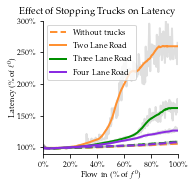

In [13]:
import matplotlib.ticker as mtick

SMOOTHS = [5,10,40]
styles = ['dashed','solid']


ratios = np.logspace(np.log10(0.001),np.log10(0.1),100)
r_idxs = [0,99]
# r_idxs=[0]
ratio = ratios[r_idxs]


fig = plt.figure(figsize=(FIG_WIDTH,FIG_HEIGHT))
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                        height_ratios=heights,
                        left=0.2,
                        bottom=0.16,
                        right=0.95,
                        top=0.9)

spec.update(wspace=0.1, hspace=0.1)
axs = fig.add_subplot(spec[0])
axs.yaxis.set_major_formatter(mtick.PercentFormatter(100))
axs.xaxis.set_major_formatter(mtick.PercentFormatter(100))

# set axs
# axs.set_title('Effect of Stopping Trucks on Latency')
plt.suptitle('Effect of Stopping Trucks on Latency')
axs.set_xlabel('Flow in ($\\%$ of $f^0$)',labelpad=0)
axs.set_xlim([0,100])
axs.set_yticks([100,150,200,250,300])
axs.set_ylim([90,300])
axs.set_ylabel('Latency ($\\%$ of $\ell^0$)',labelpad=1)

for key in keys:
    # load data
    data = pickle.load(open(SAVE_PATHS[key]+'latency.p','rb'))
    flows = data['flows']
    l = data['l']

    for i in range(len(r_idxs)):
        x = 100*flows[0:base_caps_idx[key]]/base_caps[key]
        y = 100*(l[r_idxs[i],:]/ffl[key])[0:base_caps_idx[key]]
        y_smooth = smooth(y, SMOOTHS[-i])

        axs.plot(x,y,color=GRAY,alpha=0.3)

        if i == 0 and key == '2':
            axs.plot(x,y_smooth,color=color_key[key],label='Without trucks',linestyle=styles[i])
        elif i==1:
            axs.plot(x,y_smooth,color=color_key[key],label=ratio_title[key],linestyle=styles[i])
        else:
            axs.plot(x,y_smooth,color=color_key[key],linestyle=styles[i])

        
    axs.legend()
# ax_2l.set_ylabel("Latency $(minutes)$",labelpad=0)
# ax_2l.set_xlabel("Flow $(\\frac{cars}{hour})$",labelpad=0)
# ax_2l.set_yticks([0.5,1,2])
# ax_2l.set_yticklabels(['$\\frac{1}{2}$','$1$','$2$'])
# # ax_2l.set_xticzks([0,1000,2000])
# # ax_2l.set_xlim(0,2500)
# # ax_2l.legend()

# # 3-lane next
# ax_3l.set_title("Three Lane Road")
# # plot the data
# for i in range(len(r_idxs)):
#     ax_3l.plot(flows[0:max_f_idx[1]],smooth(lane_3[r_idxs[i],:],SMOOTHS[i])[0:max_f_idx[1]],color=colors[i],label=r_labels[i])
#     ax_3l.plot(flows[0:max_f_idx[1]],lane_3[r_idxs[i],0:max_f_idx[1]],color=GRAY,alpha=0.3)
# # insert all the needed labels and axes
# # axs[1].set_ylabel("Latency $(minutes)$")
# ax_3l.set_xlabel("Flow $(\\frac{cars}{hour})$",labelpad=0)
# ax_3l.set_yticks([2,3,4])
# ax_3l.set_xticks([0,1500,3000])
# ax_3l.set_xlim(0,3500)
# ax_3l.legend()

# ax_2l.set_xlim(0,2000)
# ax_2l.set_xticks([0,1000,2000])

# # # SAVING CODE #
# # fig.tight_layout()
bbox = mpl.transforms.Bbox([[0,0],[FIG_WIDTH,FIG_HEIGHT]])
# plt.savefig('/home/mark/Documents/code/drone/analysis/'+'sumo_latency.pdf',bbox_inches=bbox)
plt.savefig('/home/mark/Documents/code/drone/sumo/results/figures/'+'sumo_latency' + '.pdf',bbox_inches=bbox)
plt.savefig('/home/mark/Documents/code/drone/sumo/results/figures/'+'sumo_latency' + '.png',bbox_inches=bbox)
plt.savefig(FINAL_SAVE+'sumo_latency' +'.pdf',bbox_inches=bbox)
plt.savefig(FINAL_SAVE+'sumo_latency' +'.png',bbox_inches=bbox)

In [8]:
flows[270]

2710